In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import imageio
import numpy
import math
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as pyplot
import scipy
from scipy import ndimage
from sklearn import decomposition

In [4]:
testSetPath = './faces/testset/'
trainSetPath = './faces/trainset/'

testImagesPaths = map(lambda path: testSetPath + path, os.listdir(testSetPath))
trainImagesPaths = map(lambda path: trainSetPath + path, os.listdir(trainSetPath))

In [5]:
def grayscaleToRGB(image):
    return numpy.array(map(lambda vector: map(lambda pixel: [pixel, pixel, pixel], vector), image))

In [6]:
testImages = map(lambda path: grayscaleToRGB(ndimage.imread(path)), testImagesPaths)
trainImages = map(lambda path: scipy.ndimage.imread(path), trainImagesPaths)

In [7]:
def RGBToYCbCr(image):
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    Y = (0.257 * R) + (0.504 * G) + (0.098 * B) + 16
    Cr = (0.439 * R) - (0.368 * G) - (0.071 * B) + 128
    Cb = -(0.148 * R) - (0.291 * G) + (0.439 * B) + 128
    
    result = numpy.empty(shape=(image.shape[0], image.shape[1], 3))
    result[:, :, 0] = Y
    result[:, :, 1] = Cr
    result[:, :, 2] = Cb
    
    return result

In [8]:
def YCbCrToRGB(image):
    Y = image[:, :, 0]
    Cr = image[:, :, 1]
    Cb = image[:, :, 2]
    
    R = 1.164 * (Y - 16) + 1.596 * (Cr - 128)
    G = 1.164 * (Y - 16) - 0.813 * (Cr - 128) - 0.391 * (Cb - 128)
    B = 1.164 * (Y - 16) + 2.018 * (Cb - 128)
    
    R = map(lambda row: map(lambda val: max(min(val, 255.0), 0.0), row), R)
    G = map(lambda row: map(lambda val: max(min(val, 255.0), 0.0), row), G)
    B = map(lambda row: map(lambda val: max(min(val, 255.0), 0.0), row), B)
    
    result = numpy.empty(shape=(image.shape[0], image.shape[1], 3)).astype(numpy.uint8)
    result[:, :, 0] = R
    result[:, :, 1] = G
    result[:, :, 2] = B
    
    return result

In [9]:
def grayscaleToYCrCb(image):
    result = numpy.empty(shape=(image.shape[0], image.shape[1], 3)).astype(numpy.uint8)
    result[:, :, 0] = image[:, :, 0]
    result[:, :, 1] = numpy.zeros(shape=image.shape[1])
    result[:, :, 2] = numpy.zeros(shape=image.shape[1])
    return result

In [10]:
def resizeToTiny(image):
    return scipy.misc.imresize(image, (32, 32))

In [11]:
tinyTestImages = map(lambda img: grayscaleToYCrCb(resizeToTiny(img)), testImages)
tinyTrainImages = map(lambda img: RGBToYCbCr(resizeToTiny(img)), trainImages)

In [12]:
trainMatrix = numpy.empty(shape=(len(tinyTrainImages), 1024))
for i in range(len(tinyTrainImages)):
    trainMatrix[i] = tinyTrainImages[i][:, :, 0].ravel()

In [14]:
trainPCA = decomposition.PCA(n_components=19)
trainPCAResult = trainPCA.fit_transform(trainMatrix)

In [15]:
def SSD(image1, image2):
    return numpy.sum((image1 - image2) ** 2)

In [16]:
def findMostSimilarImageIndex(image, imageDatabase):
    minimum = 0
    minimumIndex = -1
    
    transformedImage = trainPCA.transform([image[:,:,0].ravel()])[0]
    
    for i in range(len(imageDatabase)):        
        ssd = SSD(transformedImage, imageDatabase[i])
        
        if ssd < minimum or minimumIndex == -1:
            minimum = ssd
            minimumIndex = i
            
    return minimumIndex

In [18]:
%timeit map(lambda img: findMostSimilarImageIndex(img, trainPCAResult), tinyTestImages)
mostSimilarIndices = map(lambda img: findMostSimilarImageIndex(img, trainPCAResult), tinyTestImages)
mostSimilarTinyImages = map(lambda index: tinyTrainImages[index], mostSimilarIndices)
mostSimilarImages = map(lambda index: trainImages[index], mostSimilarIndices)

1 loop, best of 3: 18.6 s per loop


In [19]:
def transferColours(inImage, colImage):
    resizedColImage = scipy.misc.imresize(colImage, (inImage.shape[0], inImage.shape[1]))
    
    yccInImage = RGBToYCbCr(inImage)
    yccColImage = RGBToYCbCr(resizedColImage)
    
    result = numpy.empty(shape=(inImage.shape[0], inImage.shape[1], 3))
    result[:, :, 0] = yccInImage[:, :, 0]
    result[:, :, 1] = yccColImage[:, :, 1]
    result[:, :, 2] = yccColImage[:, :, 2]
    
    return YCbCrToRGB(result)

In [20]:
colTestImages = []
for i in range(len(testImages)):
    inImage = testImages[i]
    colImage = mostSimilarImages[i]
    
    result = transferColours(inImage, colImage)
    colTestImages.append(result)

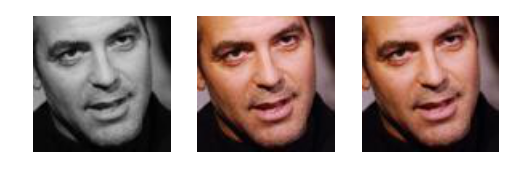

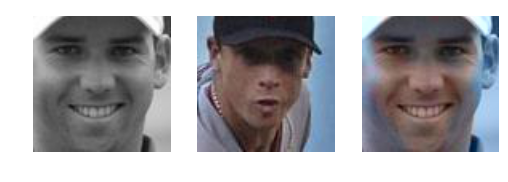

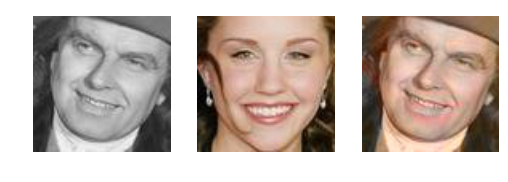

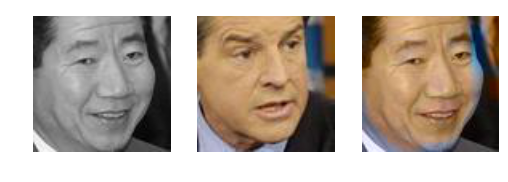

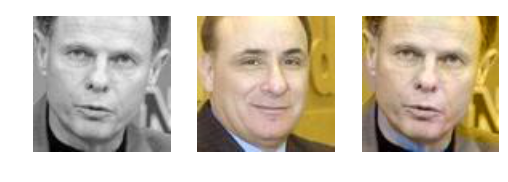

In [21]:
if not os.path.exists('./results/'):
    os.mkdir('./results/')
if not os.path.exists('./results/Task2/'):
    os.mkdir('./results/Task2/')
if not os.path.exists('./results/Task2/YCbCr'):
    os.mkdir('./results/Task2/YCbCr')

for i in range(len(testImages)):
    colTestImagePath = './results/Task2/YCbCr/' + os.listdir(testSetPath)[i]
    scipy.misc.imsave(colTestImagePath, colTestImages[i])
    
    if i >= 5:
        continue
    
    pyplot.figure()
    
    pyplot.subplot(1, 3, 1)
    pyplot.axis('off')
    pyplot.imshow(testImages[i])
    
    pyplot.subplot(1, 3, 2)
    pyplot.axis('off')
    pyplot.imshow(mostSimilarImages[i])
    
    pyplot.subplot(1, 3, 3)
    pyplot.axis('off')
    pyplot.imshow(colTestImages[i])